In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
%matplotlib inline

In [2]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate

In [3]:
## PIfunc that calculate Unique, Synergy and Redundancy of three unsymmetric varibles
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int8')
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:-shift]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[-shift:]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr[i]=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR[i]=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        Redun[i] = sum(np.minimum(PI_xR, PI_vR))/dt
    return timeshift, MIxr, MIvr, MIxvR, Redun

In [4]:
def TransferEntropy(x, y, shift):#T(x->y)
    xx = x[:-shift]#x_past
    vv = y[:-shift]#y_past
    rr = y[shift:]#y_present
    xedges = np.append(np.unique(xx),(max(xx)+1))
    vedges = np.append(np.unique(vv),(max(vv)+1))
    redges = np.append(np.unique(rr),(max(rr)+1))
    dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
    N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
    px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
    pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
    pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
    pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
    pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
    pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
    pxvr=(N/np.sum(N))
    
    T = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt
    return T

In [5]:
dt = 0.01
Tot=300
T=np.arange(dt,Tot,dt)
OX = 'RN'
# OX = 'OU'

In [6]:
if OX == 'RN':
    D = 27*10**5
    RN=np.zeros(len(T))
    mu, sigma = 0, 1
    RN=np.random.normal(mu,sigma,size = (len(T)))
#     RN = np.random.rand(len(T))
    RN = (RN-np.mean(RN))/np.std(RN)
    x_list = [RN.copy()]
    Gsigma_list = np.arange(0,102,10)
    for i in np.arange(1,len(Gsigma_list)):
        x = ndimage.gaussian_filter1d(RN, sigma=Gsigma_list[i])
        x = x.astype(float)
        x_list.append(x.copy())
elif OX == 'OU':
    # OU ; input
    tau= 1
    D = 27*10**5
    OU=np.zeros(len(T))
    mu, sigma = 0, 1
    for i in range(len(T)-1):
        OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    OU = (OU-np.mean(OU))/np.std(OU)

    # filtering for OUSmoothed
    x_list = []
    Fc_list = 2**np.arange(-1.,4.,1.)
    for Fc in Fc_list:
        b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
        x = signal.filtfilt(b, a, OU)
        x = x.astype(float)
        x_list.append(x.copy())
    Fc_list = np.append(Fc_list, 4*Fc_list[-1])
    x_list.append(OU)

In [7]:
xt_cor_list = []
vt_cor_list = []
xvt_cor_list = []
v_list = []
xstate_list = []
vstate_list = []


for i in range(len(x_list)):
    x = x_list[i].copy()
#     tv = ndimage.gaussian_filter1d(x.copy(), sigma=1, order=1, mode='reflect') / dt
    v = np.append(0,(np.diff(x)/dt))
#     v = np.zeros_like(x)
#     for j in range(len(x)-1):
#         v[j+1] = v[j]+x[j]*dt
#     v_list.append(v.copy())

    xstate = EqualState(x, 6)
    vstate = EqualState(v, 6)
    xstate_list.append(xstate.copy())
    vstate_list.append(vstate.copy())

    x_cor = np.correlate(x, x, "same")
    x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
    Taxis = np.flip(T[:len(x_cor)]-dt/2)
    xt_cor_list.append(round(np.interp(0.5*max(x_cor),  x_cor, Taxis), 5))
    x_cor = np.correlate(v, v, "same")
    x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
    Taxis = np.flip(T[:len(x_cor)]-dt/2)
    vt_cor_list.append(round(np.interp(0.5*max(x_cor),  x_cor, Taxis), 5))
    xv_cor = np.correlate(x, v, "same")
    xvt_cor_list.append(np.abs(np.argmax(xv_cor)-np.argmin(xv_cor))*dt)

In [13]:
#calculate information
window = [-0,0] # second
i = 0
dt = 1
timeshift, MIx, MIv, MIjoint, Redun = PIfunc(vstate_list[i][:], xstate_list[i][:], vstate_list[i][:], dt, [-3,3])
Ux = MIx-Redun
Uv = MIv-Redun
Syner = MIjoint-MIx-MIv+Redun
#T(x->y) = U+S = MI(x_past,[y_past,y])-MI(y_past,y)
Txy= Syner+Ux

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in multiply


In [14]:
print('Ux =',Ux)
print('Uv =',Uv)
print('S =',Syner)
print('R',Redun)

Ux = [ 2.35418330e-04  3.69969948e-04  2.34364897e-01 -5.55111512e-17
 -3.25260652e-19  3.36589376e-04  1.75219587e-04]
Uv = [1.71249384e-04 5.03184919e-05 0.00000000e+00 2.16874337e+00
 1.77869224e-01 6.79269580e-05 2.55591407e-04]
S = [3.62813479e-03 3.69657083e-03 6.50317232e-03 2.22044605e-16
 1.85542401e-01 2.88996223e-03 3.76322897e-03]
R [3.76054929e-04 2.69549607e-04 1.78741591e-01 4.16219033e-01
 8.72366209e-04 2.51941141e-04 2.91712906e-04]


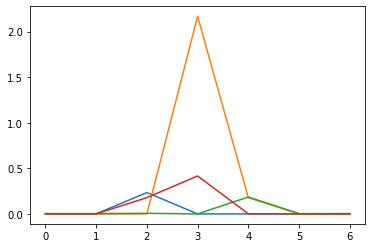

In [15]:
plt.plot(Ux)
plt.plot(Uv)
plt.plot(Syner)
plt.plot(Redun)